In [93]:
file_path = ('/kaggle/input/planets-dataset')
os.listdir(file_path)

['planet', 'test-jpg-additional']

In [94]:
planets_dir = ('/kaggle/input/planets-dataset/planet/planet')
os.listdir(planets_dir)

['sample_submission.csv', 'test-jpg', 'train_classes.csv', 'train-jpg']

In [95]:
train_set = '/kaggle/input/planets-dataset/planet/planet/train_classes.csv'
test_set = '/kaggle/input/planets-dataset/planet/planet/sample_submission.csv'
train_imgs = '/kaggle/input/planets-dataset/planet/planet/train-jpg'
test_imgs = '/kaggle/input/planets-dataset/planet/planet/test-jpg'

In [96]:
test_df = pd.read_csv(test_set)
test_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [97]:
train_df = pd.read_csv(train_set)
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim


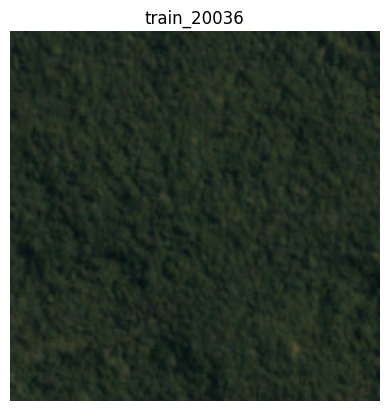

In [99]:
import matplotlib.pyplot as plt

img = Image.open(img_path).convert('RGB')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(img_name)
plt.show()

In [100]:
df = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
df['tags'] = df['tags'].apply(lambda x: x.split())

# Encode labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tags'])

# For later use
all_labels = mlb.classes_


In [101]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

In [102]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
}


In [103]:
class PlanetDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.labels = mlb.transform(df['tags'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = torch.FloatTensor(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label


In [104]:
train_data = PlanetDataset(train_df, train_imgs, transform=image_transforms['train'])
val_data = PlanetDataset(val_df, train_imgs, transform=image_transforms['val'])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 17),
    nn.Sigmoid()
)
model = model.to(device)


In [106]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [110]:
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


  0%|          | 1/570 [00:10<1:35:39, 10.09s/it]


KeyboardInterrupt: 

In [114]:
def get_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in tqdm(loader):
            images = images.to(device)
            outputs = model(images)
            preds.append(outputs.cpu().numpy())
    return np.vstack(preds)

In [117]:
test_filenames = [f.split('.')[0] for f in os.listdir(test_imgs) if f.endswith('.jpg')]
test_df = pd.DataFrame({'image_name': test_filenames})
test_dataset = PlanetDataset(test_df, test_imgs, transform=image_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_preds = get_predictions(model, test_loader)
threshold = 0.2  
predicted_tags = [[all_labels[i] for i, pred in enumerate(row) if pred > threshold] for row in test_preds]
test_df['tags'] = [' '.join(tags) for tags in predicted_tags]

KeyError: 'tags'